# Load

In [2]:
%matplotlib inline

In [141]:
import numpy as np
import scipy as sp
from scipy import integrate
from time import sleep

import matplotlib.pyplot as plt

In [142]:
import importlib
ch = importlib.import_module('control_helper')

In [202]:
ch = importlib.reload(ch)

# Dynamics

(in the repo, there is an accompanying mathematica notebook to help check these results)

Solve the Hamilton equations of motion for the state variable X of the cartpole system to find the 1st order equation of motion $\dot{X} = f(X,t)$:

\begin{align}
    \dot{x}        &= \frac{- ml \cos(\theta) p_\theta + ml^2 p_x }{d(\theta)} \\
    \dot{p_x}      &= 0 \\
    \dot{\theta}   &= \frac{ (M+m) p_\theta - ml \cos(\theta) p_x }{d(\theta)} \\
    \dot{p_\theta} &= - \frac{l^2 m p_x^2 d'(\theta )}{2 d(\theta )^2}-\frac{l m p_\theta p_x \cos (\theta ) d'(\theta )}{d(\theta )^2}+\frac{p_\theta^2 (m+M) d'(\theta )}{2 d(\theta )^2}-\frac{l m p_\theta p_x \sin (\theta )}{d(\theta )}+g l m \sin (\theta )
\end{align}

with 
$d(\theta) = ml^2 (M + m \sin^2(\theta) )$

Use ode45 to time-evolve the dynamical system, and make a movie of the result.

Comments:
- Gravity can be adjusted as an optional parameter to tool with the units.
- (An advantage of Hamilton's formalism) Friction will affect the px equation of motion only.

In [187]:
# c = ch.cartpole({'mass_cart': 5, 'mass_pole': 2, 'length_pole': .75, 'gravity': 1})
c = ch.cartpole({'mass_cart': 5, 'mass_pole': 2.1, 'length_pole': .75, 'gravity': 1})
y0 = [0, 1, 0, 0]
tmin, tmax = [0,9]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))
res = integrate.solve_ivp(c.rhs, [tmin, tmax], y0, t_eval=time)

x,px,th,pth = res.y
m = ch.movie_maker(c, x, th, time)
HTML(m.animate(2).to_html5_video())

In [155]:
c = ch.cartpole({'mass_cart': 1.492, 'mass_pole': 3, 'length_pole': .75, 'gravity': 2, 'friction': 1})

y0 = [0, 5, 0, 0]
tmin, tmax = [0,5]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))
res = integrate.solve_ivp(c.rhs, [tmin, tmax], y0, t_eval=time)

x,px,th,pth = res.y
m = ch.movie_maker(c, x, th, time)
HTML(m.animate(5).to_html5_video())

# Controllability

Find the fixed points of the dynamics. Then, compute the Jacobian and evaluate the result at the fixed points of 
$p_x \rightarrow 0, p_\theta \rightarrow 0, \theta \rightarrow 0, \pi$:

\[
    J = \left(
    \begin{array}{cccc}
     0 & \frac{1}{M} & 0 & -\frac{1}{l M} \\
     0 & -\frac{\eta }{M} & 0 & \frac{\eta }{l M} \\
     0 & -\frac{1}{l M} & 0 & \frac{m+M}{l^2 m M} \\
     0 & 0 & g l m & 0 \\
    \end{array}
    \right)
\]

The variable $s$ holds the sign associated with $\pi \Rightarrow s = -1$ and $0 \Rightarrow s = 1$. The $\eta$ refers to friction.

## Stable fixed point

In [186]:
# Control system
c = ch.cartpole({'mass_cart': 5, 'mass_pole': 2.1, 'length_pole': .75, 'gravity': 1, 'friction': 0})
tmin, tmax = [0,5.5]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.1))

yf = np.array([0, 0,np.pi,0])
y0 = np.array([0, 0,np.pi+0.5,0])

linear_res = np.array([sp.linalg.expm(c.A(-1) * t)@(y0-yf)+yf for t in time])
x,px,th,pth = linear_res.T
                   
m = ch.movie_maker(c, x, th, time)
HTML(m.animate(20).to_html5_video())

## Unstable fixed point

In [182]:
yf = np.array([0, 0, 0, 0]) # fixed point of expansion
y0 = np.array([0, 0,0.001,0]) # displacement

tmin, tmax = [0, 5.5]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))
                   
# Notice how it spirals away. We want to control this.
linear_res = np.array([sp.linalg.expm(c.A(1) * t)@(y0-yf)+yf for t in time])
x,px,th,pth = linear_res.T
m = ch.movie_maker(c, x, th, time)
HTML(m.animate(2).to_html5_video())

In [184]:
# Notice the correct dynamics for our unstable fixed point do not spiral away.      
# (Run the previous cell immediately before this one.)
res = integrate.solve_ivp(c.rhs, [tmin, tmax], y0, t_eval=time)
x,px,th,pth = res.y
m = ch.movie_maker(c, x, th, time)
HTML(m.animate(2).to_html5_video())

## Placing control poles

In [164]:
from scipy import signal

In [179]:
# Control aggressively
A = c.A(1)
B = c.B(2)
fsf = signal.place_poles(A, B, [-1-1j,-1+1j,-2-2j,-2+2j])
K = fsf.gain_matrix

yf = np.array([0, 0, 0, 0]) # fixed point of expansion
y0 = np.array([0, 0, np.pi/3, 0]) # displacement

tmin, tmax = [0, 10]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.1))
                   
linear_res = np.array([sp.linalg.expm((A-B@K) * t)@(y0-yf)+yf for t in time])
x,px,th,pth = linear_res.T

m = ch.movie_maker(c, x, th, time)
HTML(m.animate(20).to_html5_video())

In [178]:
# Control weakly
A = c.A(1)
B = c.B(2)

fsf = signal.place_poles(A, B, [-.3-1j,-.3+1j,-.5-2j,-.5+2j])
K = fsf.gain_matrix

yf = np.array([0, 0, 0, 0]) # fixed point of expansion
y0 = np.array([0, 0, np.pi/3, 0]) # displacement

tmin, tmax = [0, 15]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.1))
                   
linear_res = np.array([sp.linalg.expm((A-B@K) * t)@(y0-yf)+yf for t in time])
x,px,th,pth = linear_res.T
m = ch.movie_maker(c, x, th, time)
HTML(m.animate(20).to_html5_video())

## Linear Quadratic Regulator
Solve the algebraic ricatti equation to get a solution for the optimal control operator

In [189]:
sp.linalg.expm((A-B@K) * t)@(y0-yf)+yf

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 1)

In [198]:
X = np.array(sp.linalg.solve_continuous_are(A, B, Q, R))

In [200]:
sp.linalg.inv(R)

array([[0.1]])

In [201]:
np.array(sp.linalg.inv(R)@(B.T@X))

array([[ -0.31622777,   4.42135997, -18.35148289, -45.30330463]])

In [209]:
A = c.A(1)
B = c.B(1)

Q = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,10,0],
    [0,0,0,100]
])

R = np.array([[10]])
K,_,_ = ch.lqr(A,B,Q,R)

yf = np.array([0, 0, 0, 0]) # fixed point of expansion
y0 = np.array([0, 0, np.pi/3, 0]) # displacement

tmin, tmax = [0, 45]
time = np.linspace(tmin,tmax,int((tmax-tmin)/0.1))

linear_res = np.array([sp.linalg.expm((A-B@K) * t)@(y0-yf)+yf for t in time])
x,px,th,pth = linear_res.T
m = ch.movie_maker(c, x, th, time)
HTML(m.animate(20).to_html5_video())

In [2]:
# Check for controllability by looking at the rank of the controllability matrix
# Look at the SVD and interpret

# Check the behavior of placing eigenvalues deeper into the negative half-plane

In [ ]:
# Run the lqr for choice of Q and R to find the optimal regulator
# Look at the eigenvalues to learn what optimal control is doing
# Should see that xdot and thetadot are VERY controllable.

# Observability

In [ ]:
# Choose a sensor (let's say the position, x)
# Construct the observability matrix and check for observability
# Look at the SVD and interpret

In [123]:
c = ch.cartpole({'mass_cart': 5, 'mass_pole': 2.1, 'length_pole': .75, 'gravity': 1, 'friction': 0})
tmin, tmax = [0,20]
time = np.linspace(tmin,tmax,int((tmax-tmin)/.01))

A = c.A(-1)
B = c.B(1) # force

C = np.array([[1,0,0,0]])
D = np.array([[0]])

Wd = .1*np.identity(4)
Wn = np.array([[1]])

# Augmented control system: (u, d, n)
augB = np.hstack([B, Wd, np.zeros([4,1])])
augD = np.hstack([D, np.zeros([1,4]), Wn])

# Stable fixed point
yf = np.array([0,0,np.pi,0])
y0 = np.array([0, 0,np.pi+0.5,0])  

In [124]:
linear_res = np.array([sp.linalg.expm((A-B@K) * t)@(y0-yf)+yf for t in time])

matrix([[ 0.        ,  0.2       ,  0.        ,  0.53333333],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.53333333,  0.        ,  4.80846561],
        [ 0.        ,  0.        , -0.7875    ,  0.        ]])

In [121]:
A[1:,1:]

matrix([[ 0.        ,  0.        ,  0.        ],
        [ 0.53333333,  0.        ,  4.80846561],
        [ 0.        , -0.7875    ,  0.        ]])

In [111]:
tmin, tmax = [0, 10]
dt = 0.01
time = np.linspace(tmin,tmax,int((tmax-tmin)/dt))

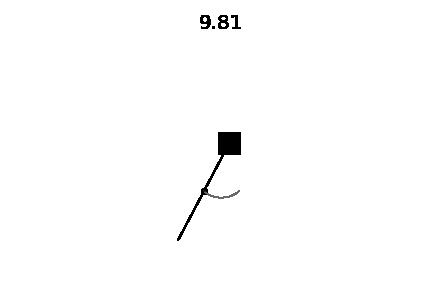

In [115]:
linear_res = np.array([sp.linalg.expm(A*t)@(y0-yf) + yf for t in time])
x,px,th,pth = linear_res.T
ch.make_movie(c,x,th,time, 20)

In [98]:
Kf, _, _ = ch.lqr(A.T, C.T, Wd, Wn)

In [101]:
Kf

matrix([[0.52806572, 0.31622777, 0.82149746, 0.04908965]])

# Observability and Controllability